In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [163]:
df=pd.read_csv("/content/Breast Cancer METABRIC.csv")

In [164]:
df.isnull().sum()

,0
Patient ID,0
Age at Diagnosis,11
Type of Breast Surgery,554
Cancer Type,0
Cancer Type Detailed,0
Cellularity,592
Chemotherapy,529
Pam50 + Claudin-low subtype,529
Cohort,11
ER status measured by IHC,83


In [165]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

In [166]:
df.shape


(2509, 34)

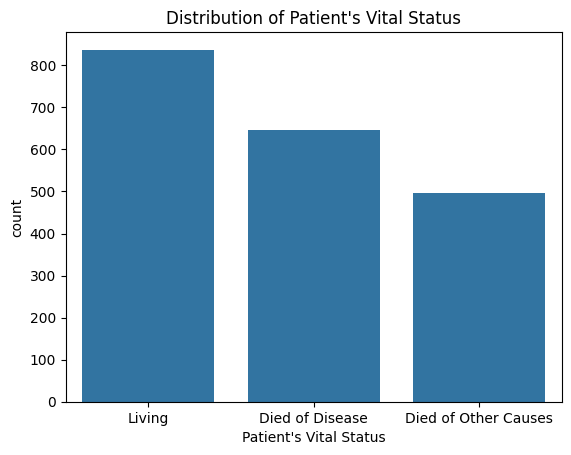

In [167]:
sns.countplot(x="Patient's Vital Status", data=df)
plt.title("Distribution of Patient's Vital Status")
plt.show()

In [168]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in df.columns:
  if df[i].dtype=='object':
    df[i]=le.fit_transform(df[i])

In [169]:
# No missing values according to df.isnull().sum(), so filling is unnecessary.
for i in df.columns:
  df[i].fillna(df[i].mean(),inplace=True)

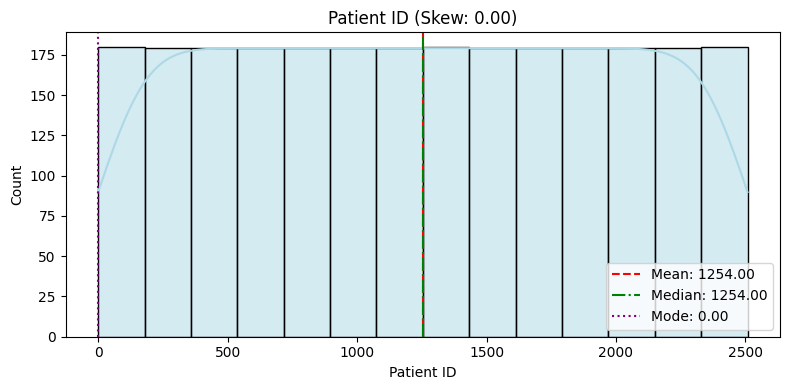

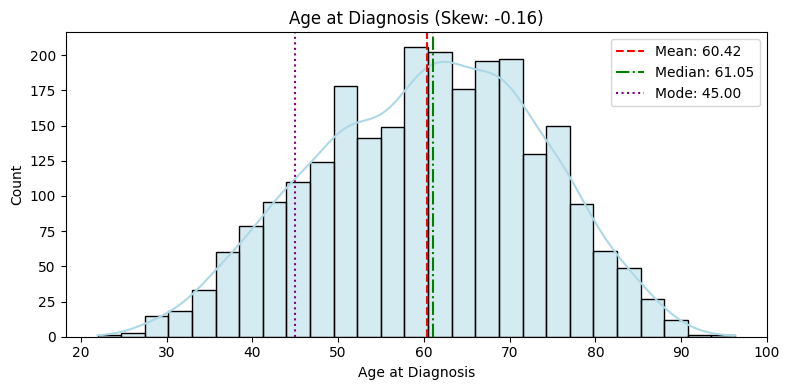

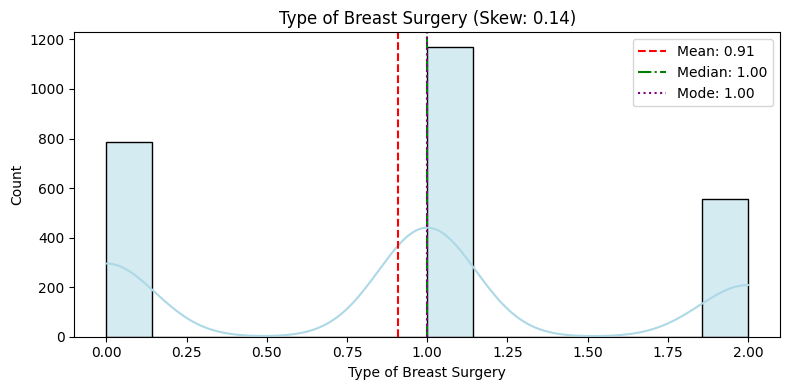

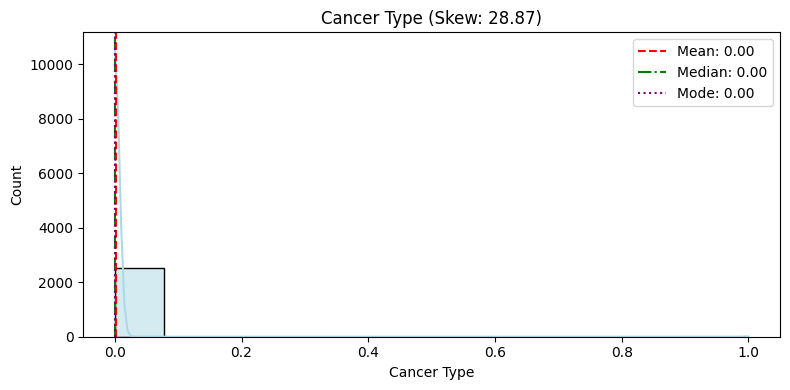

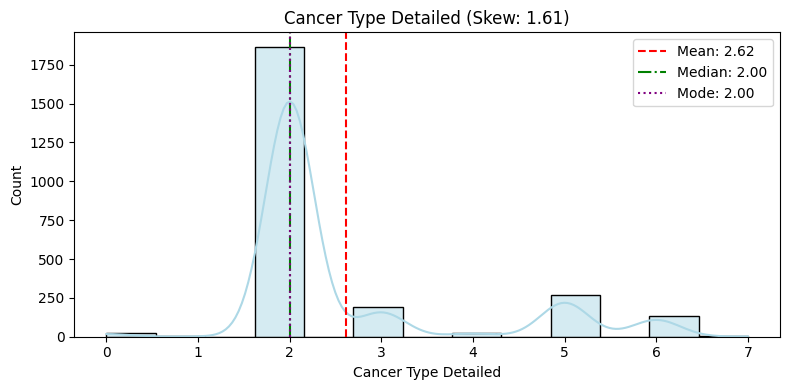

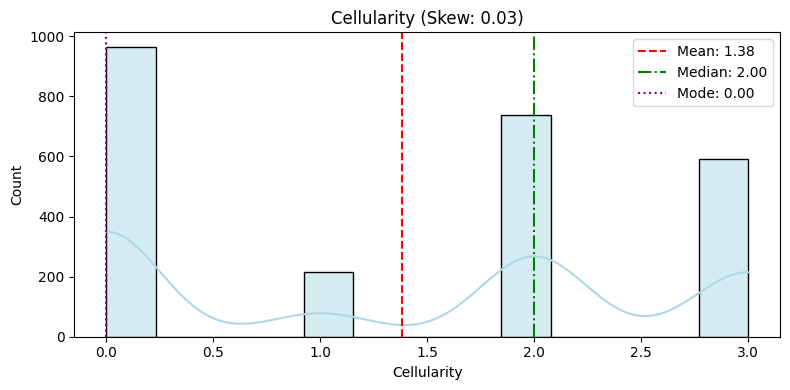

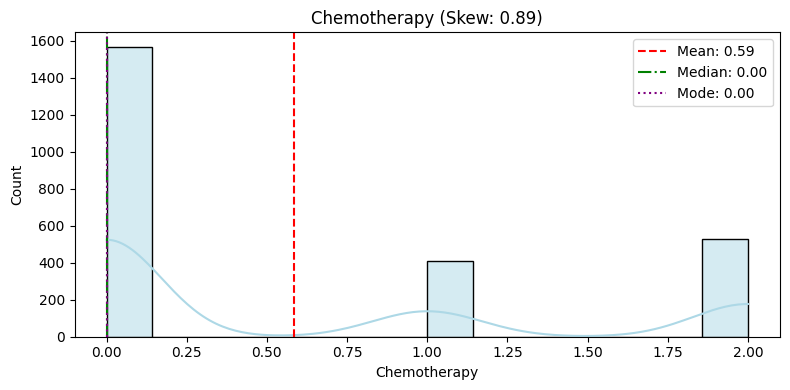

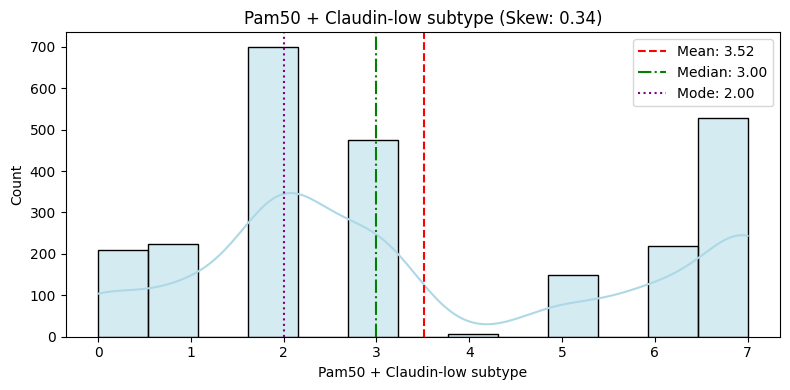

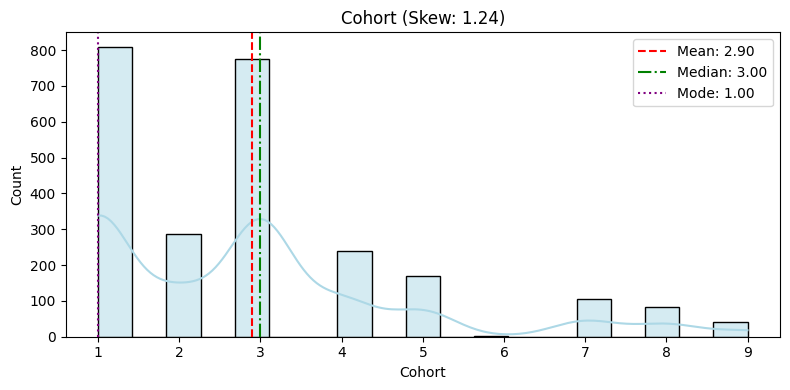

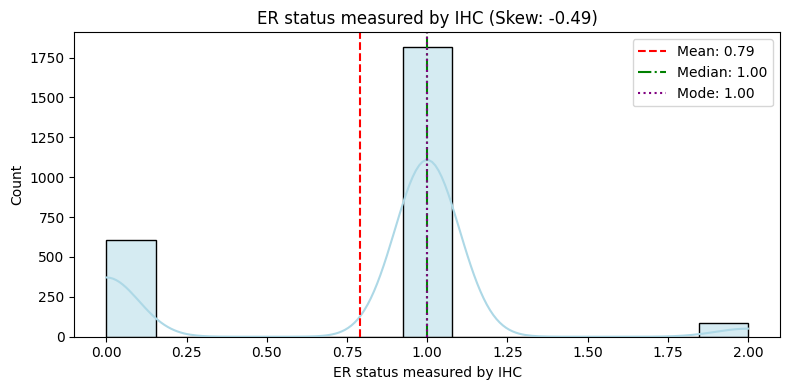

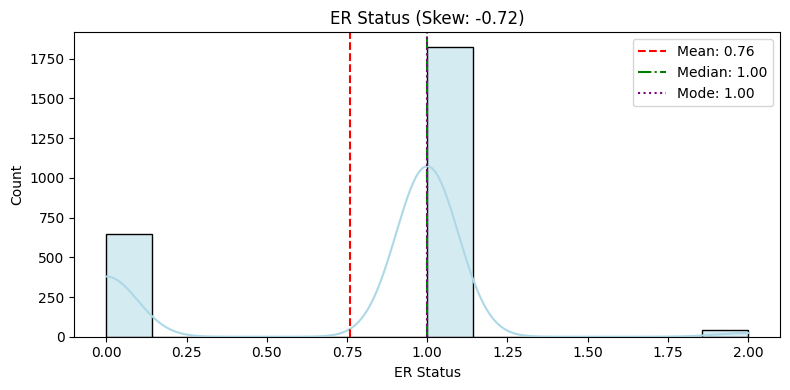

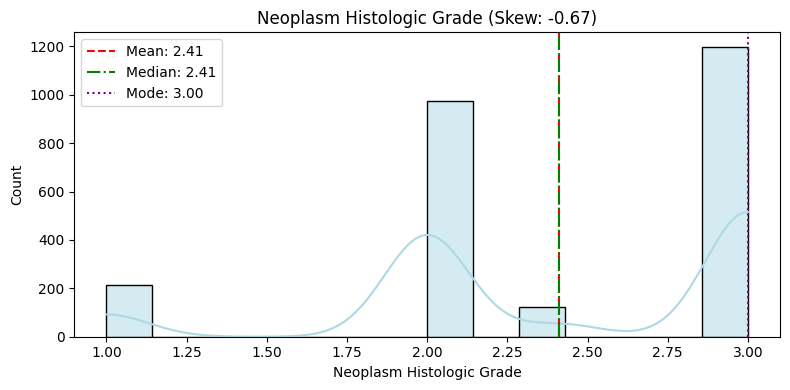

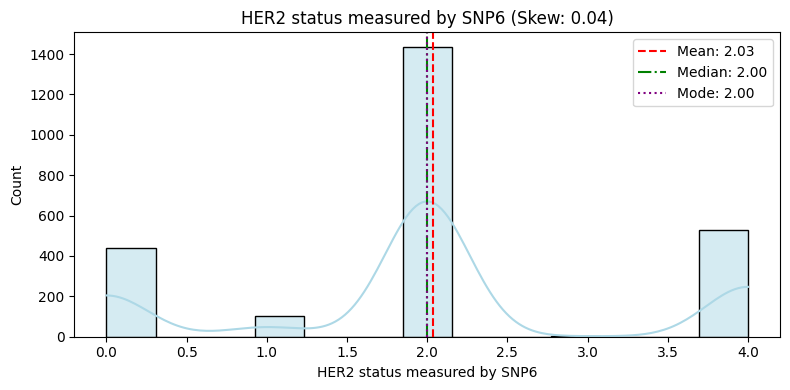

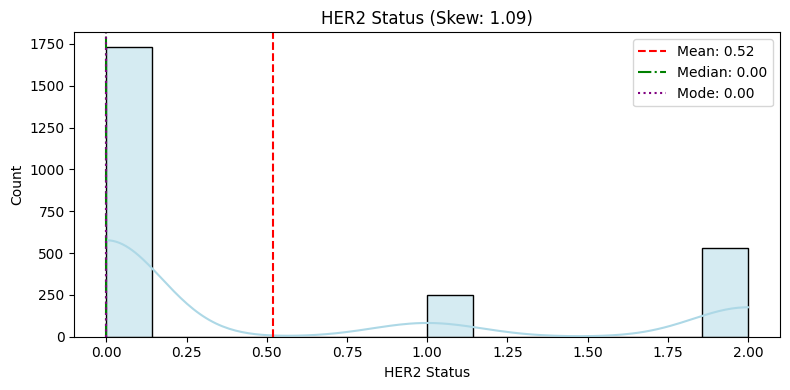

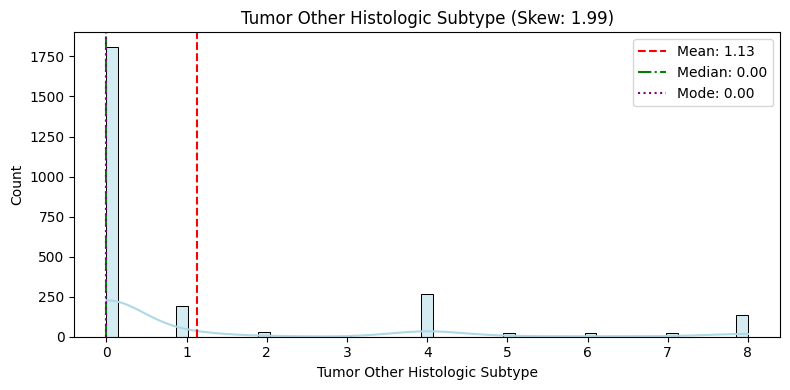

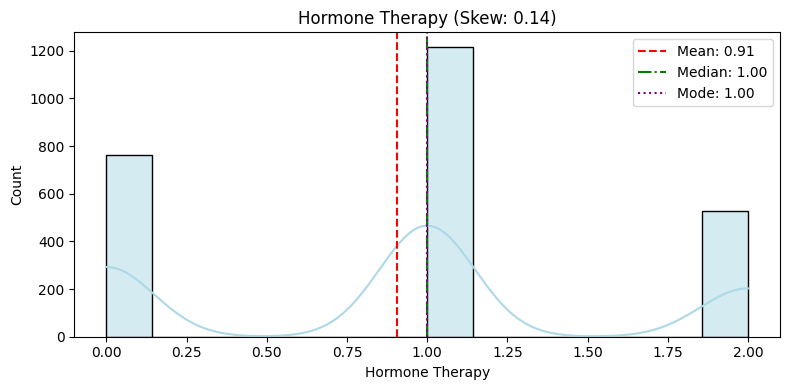

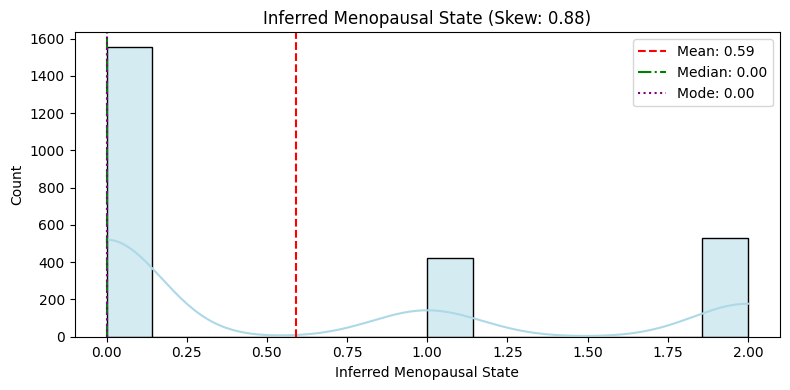

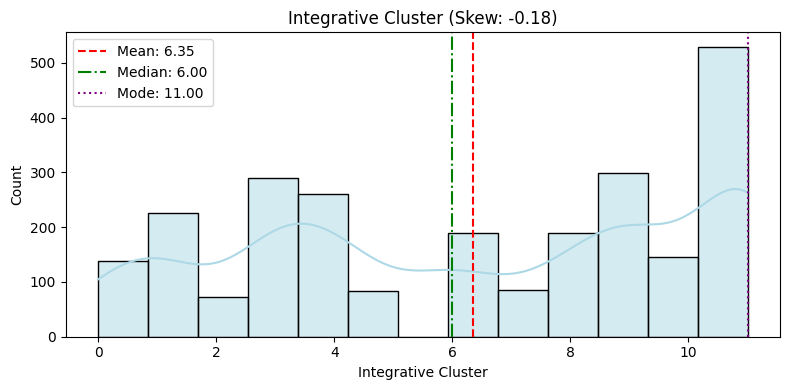

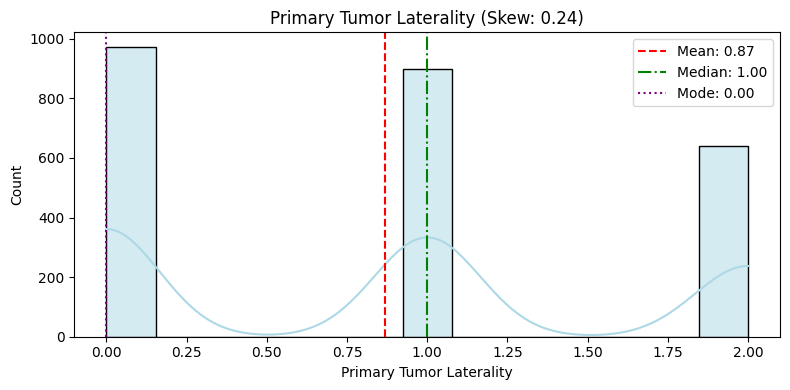

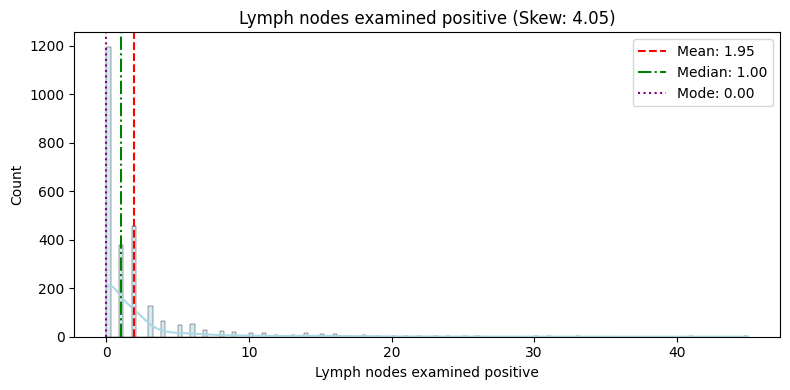

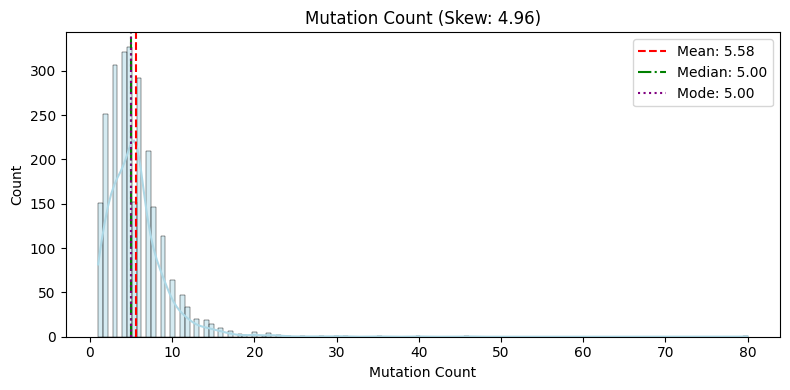

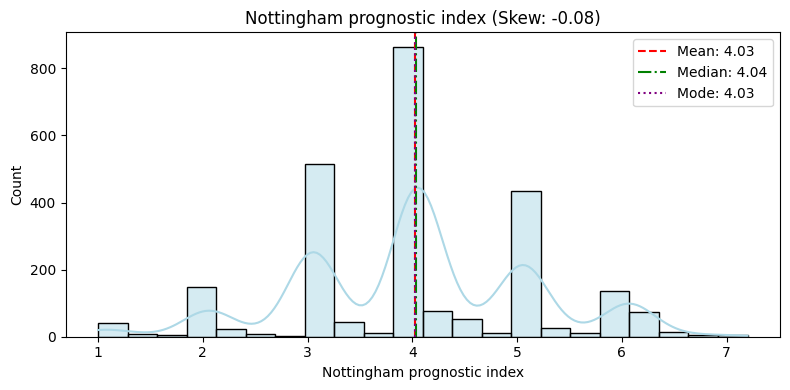

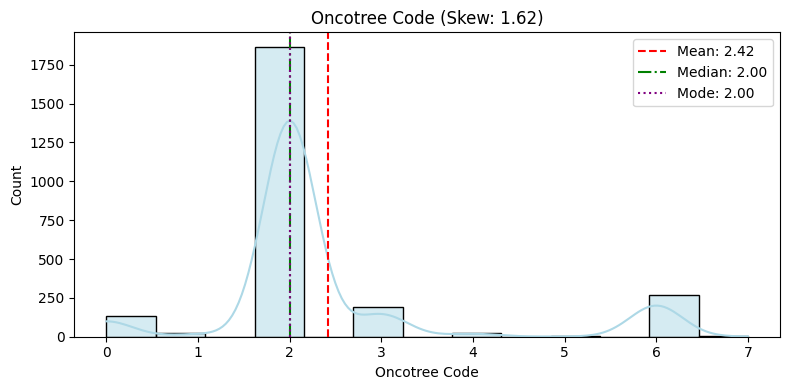

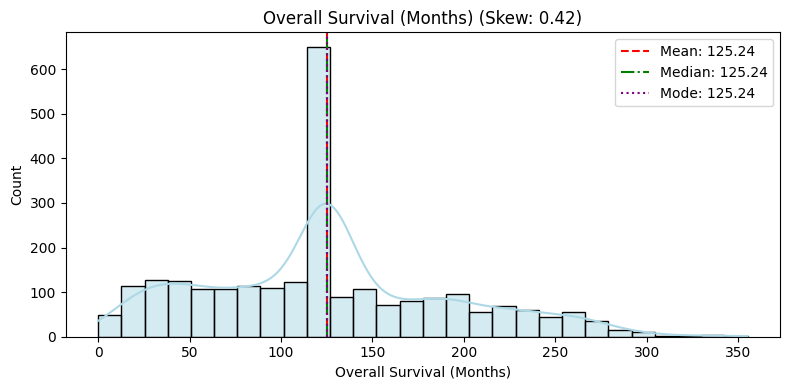

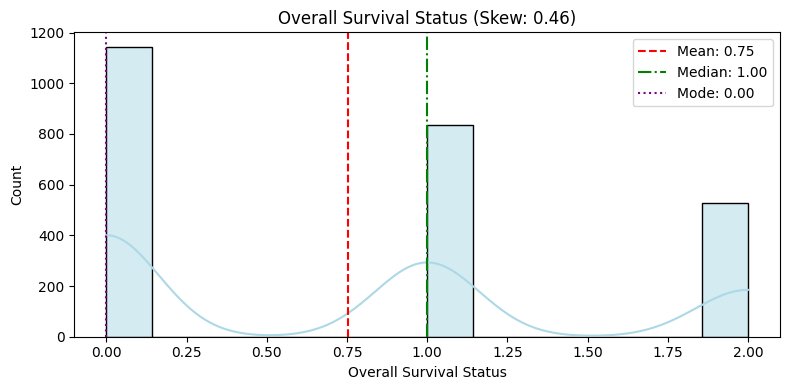

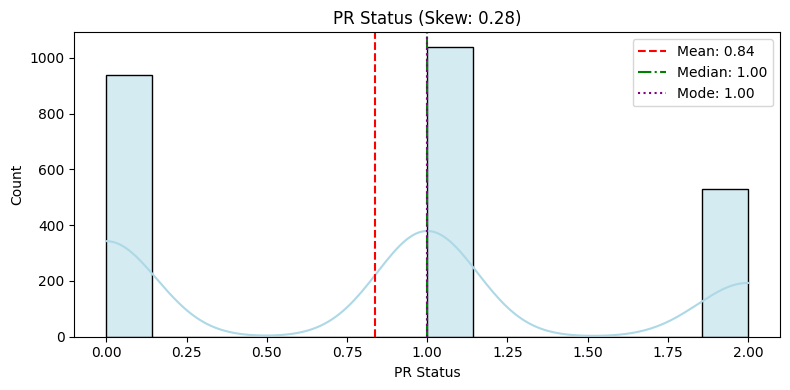

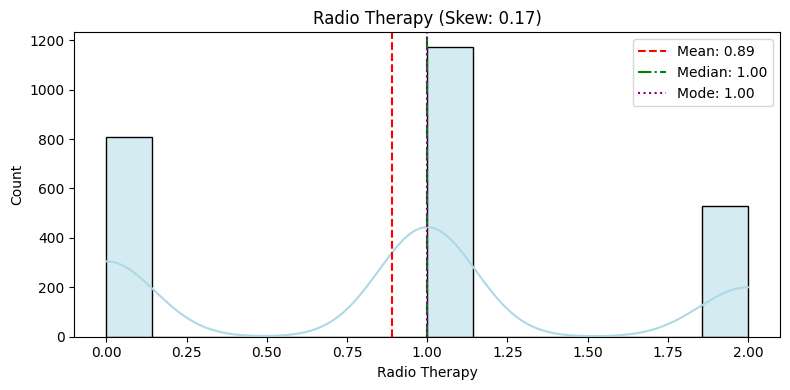

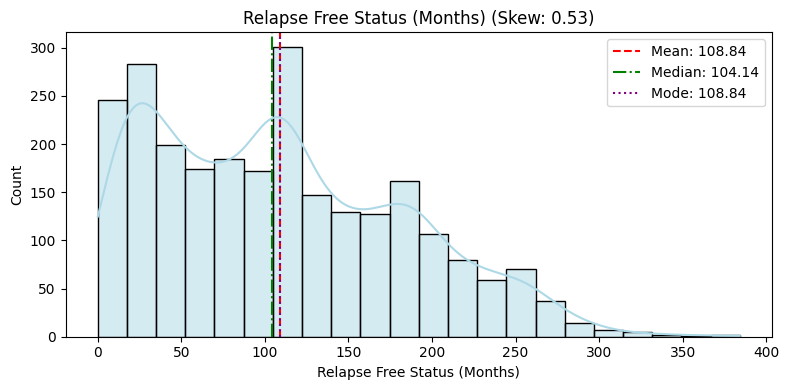

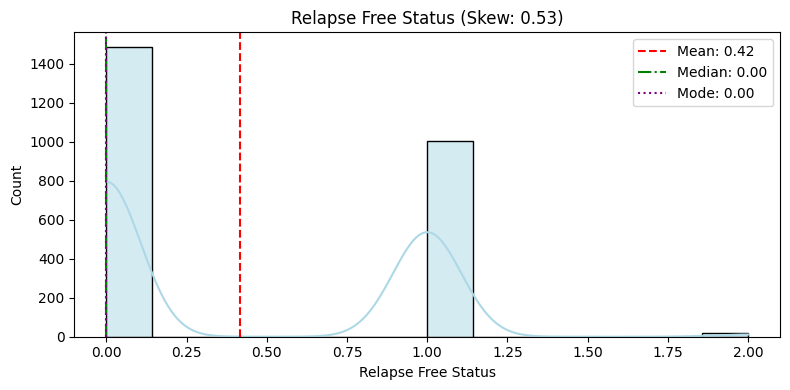

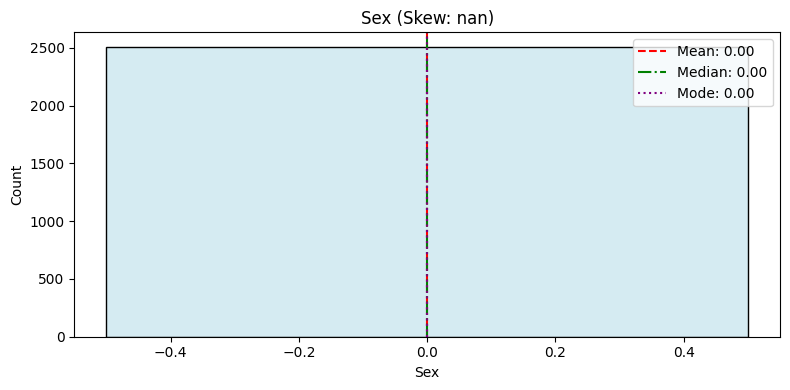

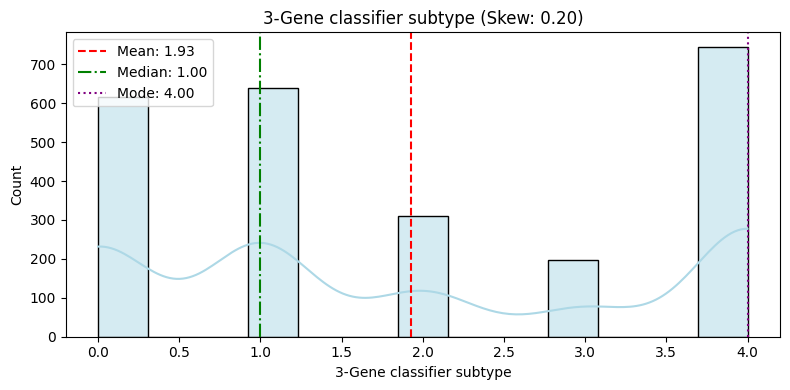

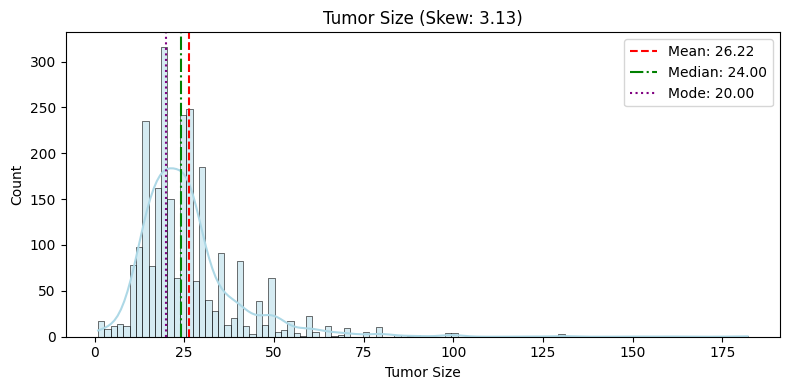

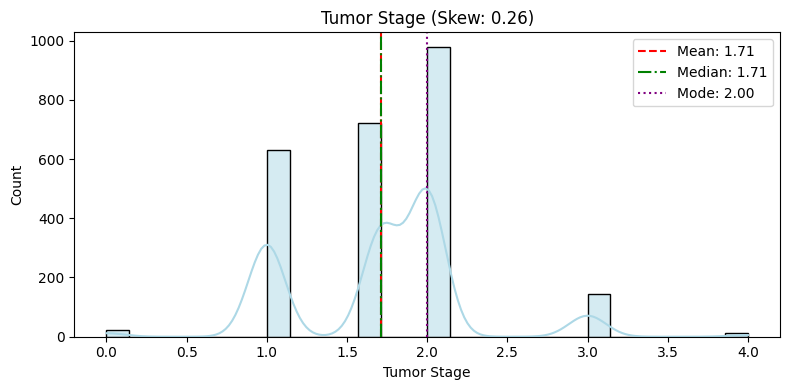

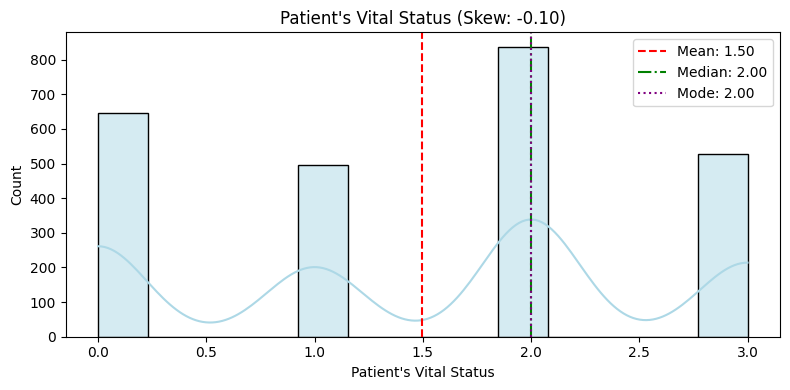

In [170]:

from scipy.stats import skew

# Loop through only numeric columns
for j in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))

    data = df[j].dropna()

    # Calculate statistics
    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().iloc[0] if not data.mode().empty else None
    skew_val = skew(data)

    # Plot histogram and KDE
    sns.histplot(data, kde=True, color='lightblue')

    # Add lines for mean, median, and mode
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-.', label=f'Median: {median_val:.2f}')
    if mode_val is not None:
        plt.axvline(mode_val, color='purple', linestyle=':', label=f'Mode: {mode_val:.2f}')

    # Add skewness in title
    plt.title(f'{j} (Skew: {skew_val:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()


<Axes: >

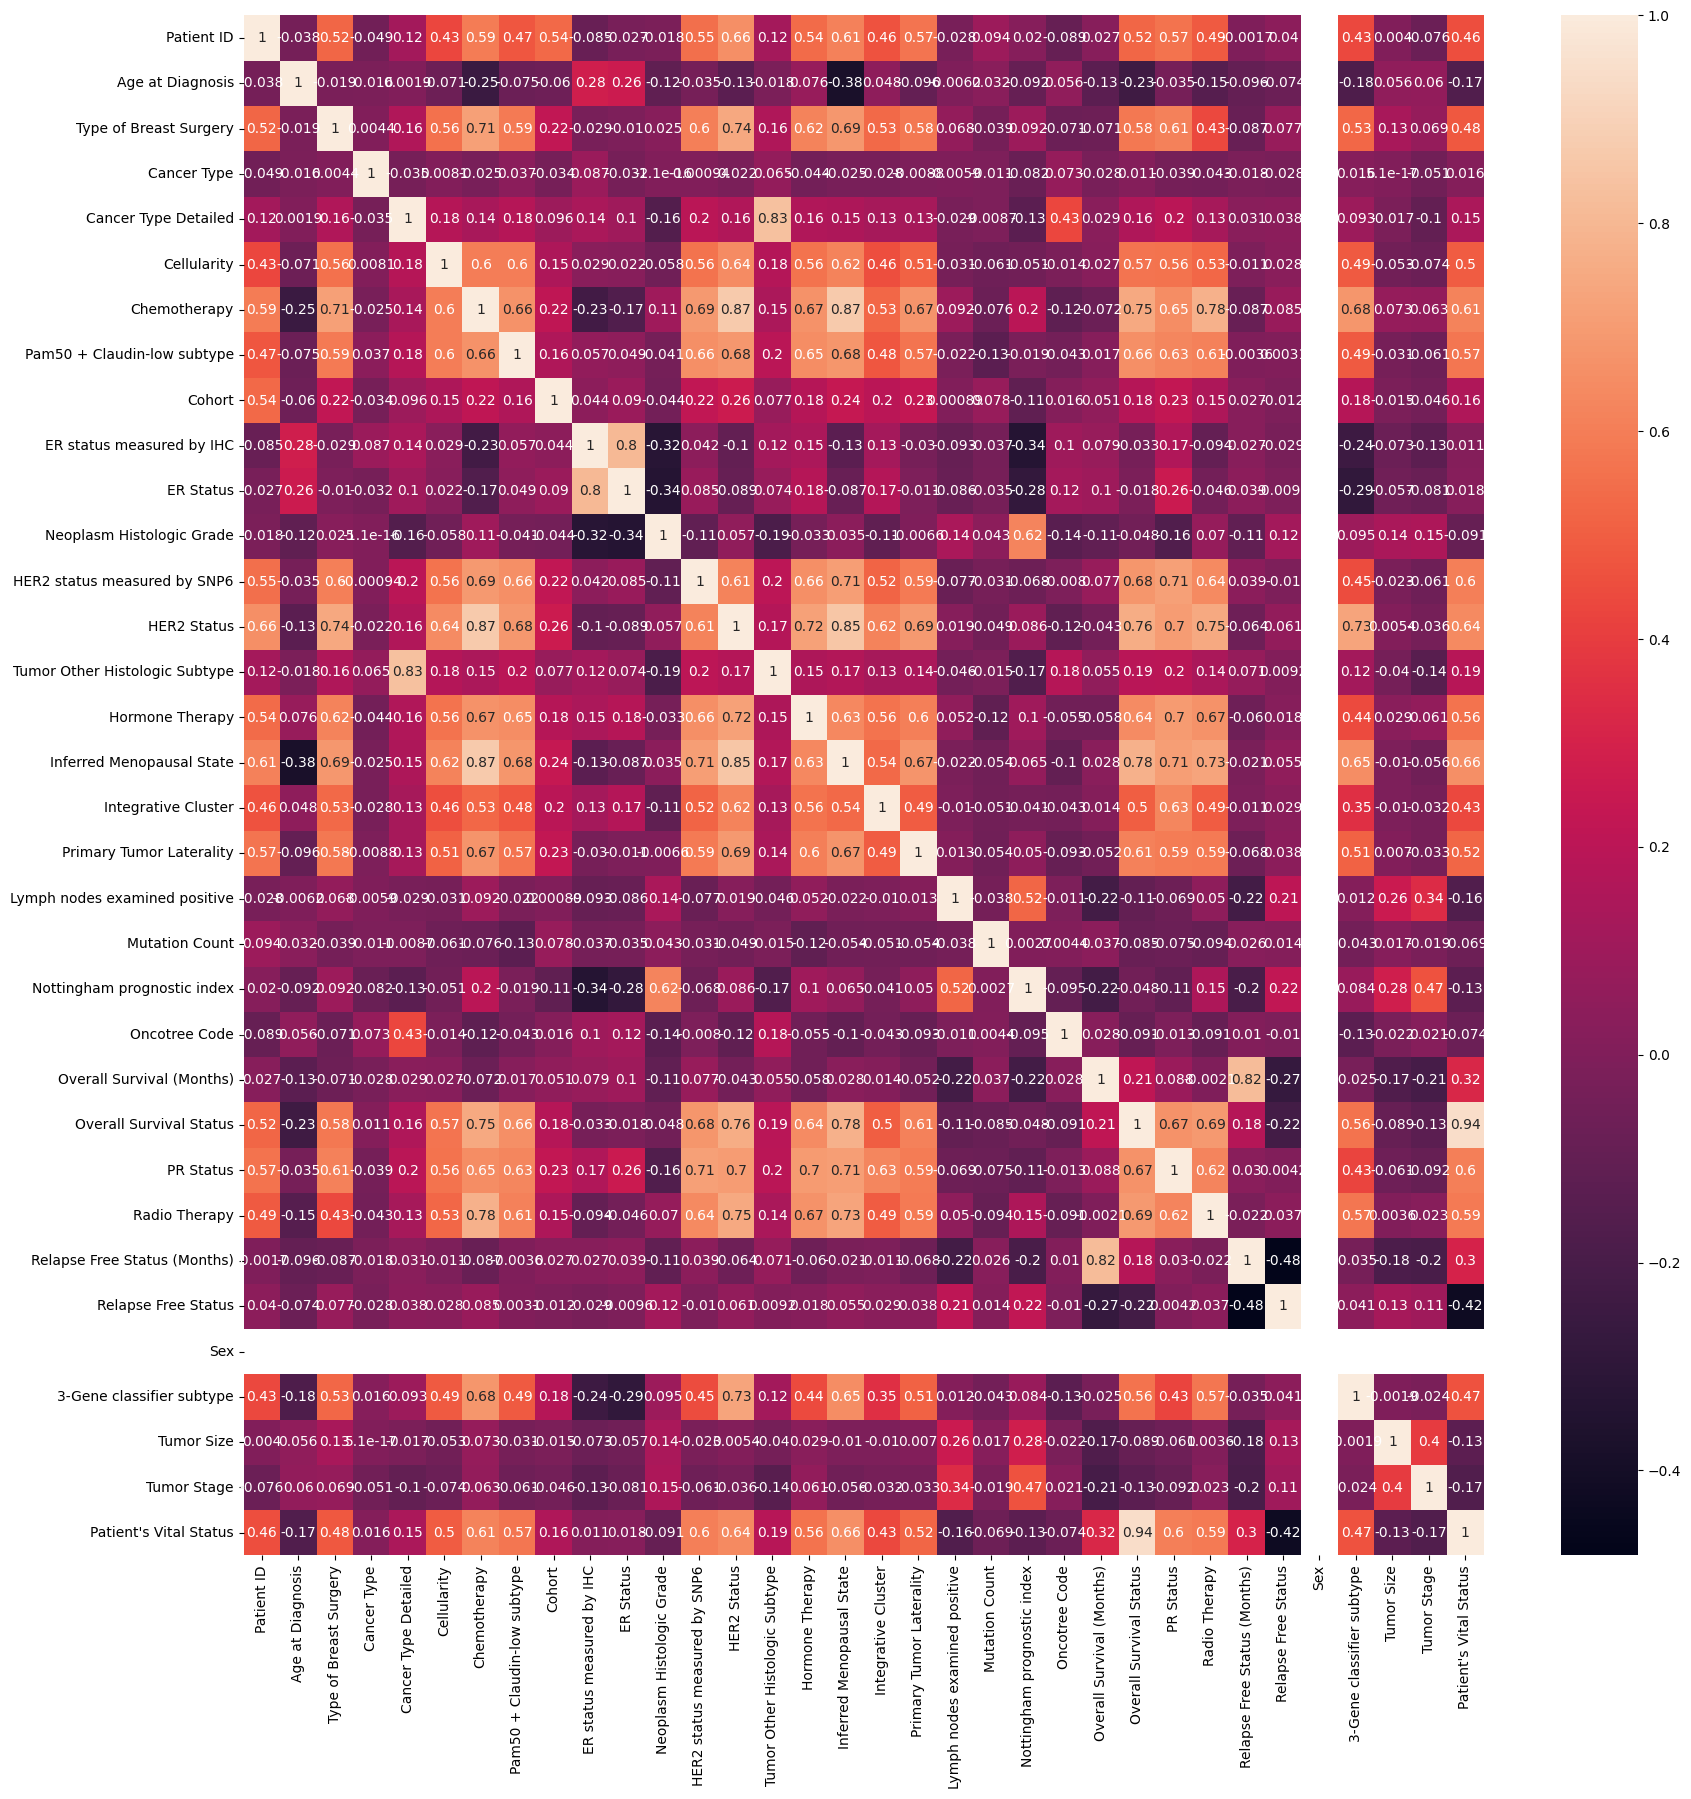

In [171]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

In [172]:
x=df.drop(columns="Patient's Vital Status")
y=df["Patient's Vital Status"]

In [191]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [174]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [175]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2007, 33), (502, 33), (2007,), (502,))

In [176]:
x_train_scaled=StandardScaler().fit_transform(x_train)
x_test_scaled=StandardScaler().fit_transform(x_test)

In [177]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train_scaled, y_train)


In [178]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RF, x_train_scaled, y_train, cv=5)
print("Cross-Validation Accuracy:", scores.mean())


Cross-Validation Accuracy: 0.9725946328209327


In [179]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train_scaled,y_train)

LogisticRegression()

In [180]:
lr.score(x_train_scaled,y_train)

0.976083707025411

In [181]:
lr.score(x_test_scaled,y_test)

0.9760956175298805

In [182]:
from sklearn.ensemble import RandomForestClassifier


In [183]:
RF=RandomForestClassifier()
RF = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,              # restrict tree depth
    min_samples_split=5,     # restrict splits
    min_samples_leaf=2,       # restrict leaf size
    random_state=42
)
RF.fit(x_train_scaled, y_train)


RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [184]:
RF.score(x_train_resampled,y_train_resampled)

0.9825148809523809

In [185]:
RF.score(x_test_scaled,y_test)

0.9741035856573705

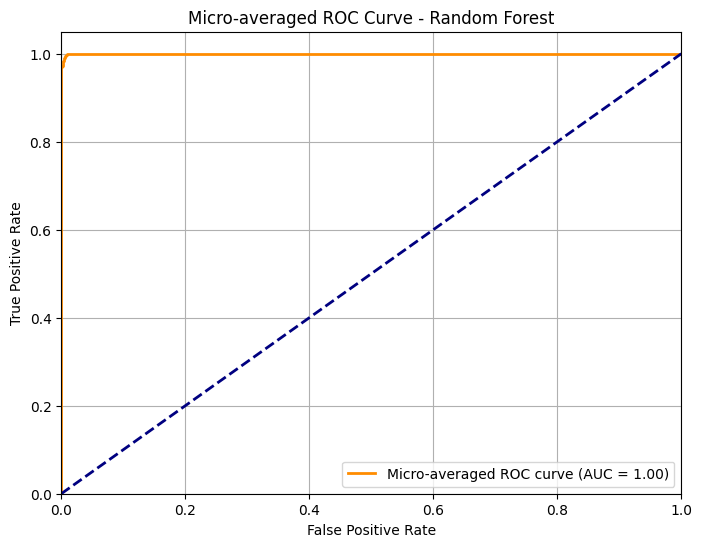

In [189]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming y_test and RF.predict_proba are available from previous steps

# Binarize y_test for micro-averaging
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities for each class
y_probs = RF.predict_proba(x_test_scaled)

# Compute micro-averaged ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2,
         label=f'Micro-averaged ROC curve (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

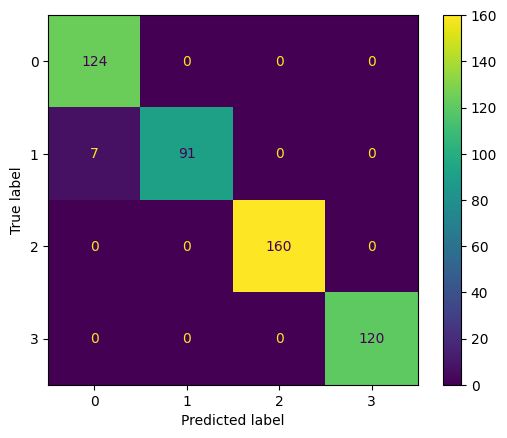

In [192]:
ConfusionMatrixDisplay.from_estimator(RF,x_test_scaled,y_test)

In [193]:
f1_score=classification_report(y_test,RF.predict(x_test_scaled))
print(f1_score)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       124
           1       1.00      0.93      0.96        98
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       120

    accuracy                           0.99       502
   macro avg       0.99      0.98      0.98       502
weighted avg       0.99      0.99      0.99       502



In [194]:
accuracy_score=accuracy_score(y_test,RF.predict(x_test_scaled))
print(accuracy_score)

0.9860557768924303
